<a href="https://colab.research.google.com/github/LSSTDESC/TheLastMetric/blob/master/MAFVariationalMutualInformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing Mutual Information Metric for Photoz

## Loading the data

In [1]:
!wget --quiet -O dataset.tar https://drive.google.com/u/0/uc?id=1wZ3UCdZyBKytp5ZS2wk5epOOy7BpYidU&export=download
!tar -xf dataset.tar
!mv for_francois dataset

mv: cannot move 'for_francois' to 'dataset/for_francois': Directory not empty


In [5]:
more dataset/README.txt

In [108]:
from astropy.table import Table
test_cat = Table.read('dataset/baseline_v1.4_10yrs/test.cat', format='ascii')

names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
z_cat = Table.read('dataset/baseline_v1.4_10yrs/zphot.cat', 
                       format='ascii', 
                       names=names_z)

names_phot=('ID', 'z_true', 
        'u', 'g', 'r', 'i', 'z', 'y', 
        'err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y', 
        'u-g', 'g-r', 'r-i', 'i-z', 'z-y',
        'err_u-g', 'err_g-r', 'err_r-i', 'err_i-z', 'err_z-y')
phot_cat = Table.read('dataset/baseline_v1.4_10yrs/test.cat', 
                       format='ascii', 
                       names=names_phot)
phot_cat = Table.from_pandas(phot_cat.to_pandas().dropna())

Populating the interactive namespace from numpy and matplotlib


(array([ 4207.,  9416., 10267.,  8282.,  6280.,  3994.,  1693.,   849.,
          409.,    70.]),
 array([0.01445425, 0.32391673, 0.6333792 , 0.94284168, 1.25230415,
        1.56176663, 1.8712291 , 2.18069157, 2.49015405, 2.79961653,
        3.109079  ]),
 <a list of 10 Patch objects>)

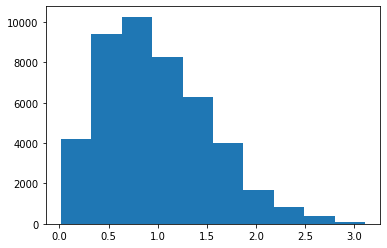

In [3]:
%pylab inline
hist(phot_cat['z_true'])

## Building a Mutual Information Lower Bound

In [11]:
!pip install --quiet flax

     |████████████████████████████████| 92kB 3.6MB/s 


In [10]:
#@title Some useful code

import numpy as onp
import jax.numpy as jnp
 
from tensorflow_probability.python.internal.backend import jax as tf
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
 
bijector_lib = tfp.bijectors.bijector
 
__all__ = [
    'RealNVP'
]
 
class RealNVP(bijector_lib.Bijector):
  """RealNVP 'affine coupling layer' for vector-valued events.
  Real NVP models a normalizing flow on a `D`-dimensional distribution via a
  single `D-d`-dimensional conditional distribution [(Dinh et al., 2017)][1]:
  `y[d:D] = x[d:D] * tf.exp(log_scale_fn(x[0:d])) + shift_fn(x[0:d])`
  `y[0:d] = x[0:d]`
  The last `D-d` units are scaled and shifted based on the first `d` units only,
  while the first `d` units are 'masked' and left unchanged. Real NVP's
  `shift_and_log_scale_fn` computes vector-valued quantities. For
  scale-and-shift transforms that do not depend on any masked units, i.e.
  `d=0`, use the `tfb.Affine` bijector with learned parameters instead.
  Masking is currently only supported for base distributions with
  `event_ndims=1`. For more sophisticated masking schemes like checkerboard or
  channel-wise masking [(Papamakarios et al., 2016)[4], use the `tfb.Permute`
  bijector to re-order desired masked units into the first `d` units. For base
  distributions with `event_ndims > 1`, use the `tfb.Reshape` bijector to
  flatten the event shape.
  Recall that the MAF bijector [(Papamakarios et al., 2016)][4] implements a
  normalizing flow via an autoregressive transformation. MAF and IAF have
  opposite computational tradeoffs - MAF can train all units in parallel but
  must sample units sequentially, while IAF must train units sequentially but
  can sample in parallel. In contrast, Real NVP can compute both forward and
  inverse computations in parallel. However, the lack of an autoregressive
  transformations makes it less expressive on a per-bijector basis.
  A 'valid' `shift_and_log_scale_fn` must compute each `shift` (aka `loc` or
  'mu' in [Papamakarios et al. (2016)][4]) and `log(scale)` (aka 'alpha' in
  [Papamakarios et al. (2016)][4]) such that each are broadcastable with the
  arguments to `forward` and `inverse`, i.e., such that the calculations in
  `forward`, `inverse` [below] are possible. For convenience,
  `real_nvp_default_nvp` is offered as a possible `shift_and_log_scale_fn`
  function.
  NICE [(Dinh et al., 2014)][2] is a special case of the Real NVP bijector
  which discards the scale transformation, resulting in a constant-time
  inverse-log-determinant-Jacobian. To use a NICE bijector instead of Real
  NVP, `shift_and_log_scale_fn` should return `(shift, None)`, and
  `is_constant_jacobian` should be set to `True` in the `RealNVP` constructor.
  Calling `real_nvp_default_template` with `shift_only=True` returns one such
  NICE-compatible `shift_and_log_scale_fn`.
  The `bijector_fn` argument allows specifying a more general coupling relation,
  such as the LSTM-inspired activation from [5], or Neural Spline Flow [6].
  Caching: the scalar input depth `D` of the base distribution is not known at
  construction time. The first call to any of `forward(x)`, `inverse(x)`,
  `inverse_log_det_jacobian(x)`, or `forward_log_det_jacobian(x)` memoizes
  `D`, which is re-used in subsequent calls. This shape must be known prior to
  graph execution (which is the case if using tf.layers).
  #### Examples
  ```python
  tfd = tfp.distributions
  tfb = tfp.bijectors
  # A common choice for a normalizing flow is to use a Gaussian for the base
  # distribution. (However, any continuous distribution would work.) E.g.,
  nvp = tfd.TransformedDistribution(
      distribution=tfd.MultivariateNormalDiag(loc=[0., 0., 0.]),
      bijector=tfb.RealNVP(
          num_masked=2,
          shift_and_log_scale_fn=tfb.real_nvp_default_template(
              hidden_layers=[512, 512])))
  x = nvp.sample()
  nvp.log_prob(x)
  nvp.log_prob(0.)
  ```
  For more examples, see [Jang (2018)][3].
  #### References
  [1]: Laurent Dinh, Jascha Sohl-Dickstein, and Samy Bengio. Density Estimation
       using Real NVP. In _International Conference on Learning
       Representations_, 2017. https://arxiv.org/abs/1605.08803
  [2]: Laurent Dinh, David Krueger, and Yoshua Bengio. NICE: Non-linear
       Independent Components Estimation. _arXiv preprint arXiv:1410.8516_,
       2014. https://arxiv.org/abs/1410.8516
  [3]: Eric Jang. Normalizing Flows Tutorial, Part 2: Modern Normalizing Flows.
       _Technical Report_, 2018. http://blog.evjang.com/2018/01/nf2.html
  [4]: George Papamakarios, Theo Pavlakou, and Iain Murray. Masked
       Autoregressive Flow for Density Estimation. In _Neural Information
       Processing Systems_, 2017. https://arxiv.org/abs/1705.07057
  [5]: Diederik P Kingma, Tim Salimans, Max Welling. Improving Variational
       Inference with Inverse Autoregressive Flow. In _Neural Information
       Processing Systems_, 2016. https://arxiv.org/abs/1606.04934
  [6]: Conor Durkan, Artur Bekasov, Iain Murray, George Papamakarios. Neural
       Spline Flows, 2019. http://arxiv.org/abs/1906.04032
  """
 
  def __init__(self,
               num_masked=None,
               fraction_masked=None,
               shift_and_log_scale_fn=None,
               bijector_fn=None,
               is_constant_jacobian=False,
               validate_args=False,
               name=None):
    """Creates the Real NVP or NICE bijector.
    Args:
      num_masked: Python `int`, indicating the number of units of the
        event that should should be masked. Must be in the closed interval
        `[0, D-1]`, where `D` is the event size of the base distribution.
        If the value is negative, then the last `d` units of the event are
        masked instead. Must be `None` if `fraction_masked` is defined.
      fraction_masked: Python `float`, indicating the number of units of the
        event that should should be masked. Must be in the closed interval
        `[-1, 1]`, and the value represents the fraction of the values to be
        masked. The final number of values to be masked will be the input size
        times the fraction, rounded to the the nearest integer towards zero.
        If negative, then the last fraction of units are masked instead. Must
        be `None` if `num_masked` is defined.
      shift_and_log_scale_fn: Python `callable` which computes `shift` and
        `log_scale` from both the forward domain (`x`) and the inverse domain
        (`y`). Calculation must respect the 'autoregressive property' (see class
        docstring). Suggested default
        `masked_autoregressive_default_template(hidden_layers=...)`.
        Typically the function contains `tf.Variables` and is wrapped using
        `tf.make_template`. Returning `None` for either (both) `shift`,
        `log_scale` is equivalent to (but more efficient than) returning zero.
      bijector_fn: Python `callable` which returns a `tfb.Bijector` which
        transforms the last `D-d` unit with the signature `(masked_units_tensor,
        output_units, **condition_kwargs) -> bijector`. The bijector must
        operate on scalar or vector events and must not alter the rank of its
        input.
      is_constant_jacobian: Python `bool`. Default: `False`. When `True` the
        implementation assumes `log_scale` does not depend on the forward domain
        (`x`) or inverse domain (`y`) values. (No validation is made;
        `is_constant_jacobian=False` is always safe but possibly computationally
        inefficient.)
      validate_args: Python `bool` indicating whether arguments should be
        checked for correctness.
      name: Python `str`, name given to ops managed by this object.
    Raises:
      ValueError: If both or none of `shift_and_log_scale_fn` and `bijector_fn`
          are specified.
    """
    parameters = dict(locals())
    name = name or 'real_nvp'
    with tf.name_scope(name) as name:
      # At construction time, we don't know input_depth.
      self._input_depth = None
      if num_masked is not None and fraction_masked is not None:
        raise ValueError('Exactly one of `num_masked` and '
                         '`fraction_masked` should be specified.')
 
      if num_masked is not None:
        if int(num_masked) != num_masked:
          raise TypeError('`num_masked` must be an integer. Got: {} of type {}'
                          ''.format(num_masked, type(num_masked)))
        self._num_masked = int(num_masked)
        self._fraction_masked = None
        self._reverse_mask = self._num_masked < 0
      else:
        if not np.issubdtype(type(fraction_masked), np.floating):
          raise TypeError('`fraction_masked` must be a float. Got: {} of type '
                          '{}'.format(fraction_masked, type(fraction_masked)))
        if np.abs(fraction_masked) >= 1.:
          raise ValueError(
              '`fraction_masked` must be in (-1, 1), but is {}.'.format(
                  fraction_masked))
        self._num_masked = None
        self._fraction_masked = float(fraction_masked)
        self._reverse_mask = self._fraction_masked < 0
 
      if shift_and_log_scale_fn is not None and bijector_fn is not None:
        raise ValueError('Exactly one of `shift_and_log_scale_fn` and '
                         '`bijector_fn` should be specified.')
 
      if shift_and_log_scale_fn:
        def _bijector_fn(x0, input_depth, **condition_kwargs):
          shift, log_scale = shift_and_log_scale_fn(x0, input_depth,
                                                    **condition_kwargs)
          return affine_scalar.AffineScalar(shift=shift, log_scale=log_scale)
 
        bijector_fn = _bijector_fn
      #
      # if validate_args:
      #   bijector_fn = _validate_bijector_fn(bijector_fn)
 
      # Still do this assignment for variable tracking.
      self._shift_and_log_scale_fn = shift_and_log_scale_fn
      self._bijector_fn = bijector_fn
 
      super(RealNVP, self).__init__(
          forward_min_event_ndims=1,
          is_constant_jacobian=is_constant_jacobian,
          validate_args=validate_args,
          parameters=parameters,
          name=name)
 
  @property
  def _masked_size(self):
    masked_size = (
        self._num_masked if self._num_masked is not None else int(
            np.round(self._input_depth * self._fraction_masked)))
    return masked_size
 
  def _cache_input_depth(self, x):
    if self._input_depth is None:
      self._input_depth = x.shape[-1]
      if self._input_depth is None:
        raise NotImplementedError(
            'Rightmost dimension must be known prior to graph execution.')
 
      if abs(self._masked_size) >= self._input_depth:
        raise ValueError(
            'Number of masked units {} must be smaller than the event size {}.'
            .format(self._masked_size, self._input_depth))
 
  def _bijector_input_units(self):
    return self._input_depth - abs(self._masked_size)
 
  def _forward(self, x, **condition_kwargs):
    self._cache_input_depth(x)
 
    x0, x1 = x[..., :self._masked_size], x[..., self._masked_size:]
 
    if self._reverse_mask:
      x0, x1 = x1, x0
 
    y1 = self._bijector_fn(x0, self._bijector_input_units(),
                           **condition_kwargs).forward(x1)
 
    if self._reverse_mask:
      y1, x0 = x0, y1
 
    y = tf.concat([x0, y1], axis=-1)
    return y
 
  def _inverse(self, y, **condition_kwargs):
    self._cache_input_depth(y)
 
    y0, y1 = y[..., :self._masked_size], y[..., self._masked_size:]
 
    if self._reverse_mask:
      y0, y1 = y1, y0
 
    x1 = self._bijector_fn(y0, self._bijector_input_units(),
                           **condition_kwargs).inverse(y1)
 
    if self._reverse_mask:
      x1, y0 = y0, x1
 
    x = tf.concat([y0, x1], axis=-1)
    return x
 
  def _forward_log_det_jacobian(self, x, **condition_kwargs):
    self._cache_input_depth(x)
 
    x0, x1 = x[..., :self._masked_size], x[..., self._masked_size:]
 
    if self._reverse_mask:
      x0, x1 = x1, x0
 
    return self._bijector_fn(x0, self._bijector_input_units(),
                             **condition_kwargs).forward_log_det_jacobian(
                                 x1, event_ndims=1)
 
  def _inverse_log_det_jacobian(self, y, **condition_kwargs):
    self._cache_input_depth(y)
 
    y0, y1 = y[..., :self._masked_size], y[..., self._masked_size:]
 
    if self._reverse_mask:
      y0, y1 = y1, y0
 
    return self._bijector_fn(y0, self._bijector_input_units(),
                             **condition_kwargs).inverse_log_det_jacobian(
                                 y1, event_ndims=1)

In [11]:
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
import flax 
from flax import nn
import jax
import jax.numpy as np
import numpy as onp

tfb = tfp.bijectors
tfd = tfp.distributions

In [12]:
@nn.module
def NeuralSpline(x, nunits=1, nbins=32):
  def bin_positions(x):
    x = np.reshape(x, [-1, nunits, nbins])
    return nn.activation.softmax(x, axis=-1) *  (2. - nbins * 1e-2) + 1e-2
  
  def slopes(x):
    x = np.reshape(x, [-1, nunits, nbins - 1])
    return nn.activation.softplus(x) + 1e-2

  # Let's have one more non stupid layer
  net = nn.leaky_relu(nn.Dense(x, 128))
  net = nn.leaky_relu(nn.Dense(net, 128))

  bin_widths = bin_positions(nn.Dense(net, nunits*nbins))
  bin_heights = bin_positions(nn.Dense(net, nunits*nbins))
  knot_slopes = slopes(nn.Dense(net, nunits*(nbins-1)))

  return tfb.RationalQuadraticSpline(
            bin_widths=bin_widths,
            bin_heights=bin_heights,
            knot_slopes=knot_slopes)

In [72]:
@nn.module
def ConditionalDensityEstimator(x):
  # Some input processing
  net = nn.BatchNorm(x)
  net = nn.leaky_relu(nn.Dense(net, 512))
  net = nn.BatchNorm(net)
  net = nn.leaky_relu(nn.Dense(net, 512))
  net = nn.BatchNorm(net)
  net = nn.leaky_relu(nn.Dense(net, 512))


  loc = nn.Dense(net,1)
  scale= nn.softplus(nn.Dense(net,1))

  # spline1 = NeuralSpline.shared(name='spline1')
  # spline2 = NeuralSpline.shared(name='spline2')  

  # And here we define some simple normalizing flow
  bijector_chain = tfb.Chain([       
        tfb.Scale(3.5/2.),
        tfb.Shift(1.0),
        tfb.Tanh(),
        # tfb.Scale(10.),        
        # spline1(net),    
        # tfb.Scale(0.1)
  ])

  distribution = tfd.TransformedDistribution(tfd.Normal(loc=loc, scale=scale),
                                             bijector_chain)
  return distribution

u-g', 'g-r', 'r-i', 'i-z', 'z-y',

In [85]:
batch_size = 512
def get_batch():
  inds = onp.random.choice(len(phot_cat), size=batch_size)
  x = np.stack([phot_cat['u-g'][inds], phot_cat['g-r'][inds], phot_cat['r-i'][inds],
                phot_cat['i-z'][inds],phot_cat['z-y'][inds] ]).astype('float32').T
  y = np.array(phot_cat['z_true'][inds]).astype('float32').reshape((-1,1))
  return {'x':x, 'y':y}

In [88]:
@jax.jit
def train_step(optimizer, batch):
  def loss_fn(model):
    distribution = model(batch['x'])
    loss = - np.mean(distribution.log_prob(batch['y']))
    return loss
  l, grad = jax.value_and_grad(loss_fn)(optimizer.target)

  optimizer = optimizer.apply_gradient(grad)
  return optimizer, l

_, initial_params = ConditionalDensityEstimator.init_by_shape(jax.random.PRNGKey(0),
                                           [((1, 5), np.float32)])

model = flax.nn.Model(ConditionalDensityEstimator, initial_params)

optimizer = flax.optim.Adam(learning_rate=0.001).create(model)

losses = []

In [89]:
for epoch in range(10000):
  batch = get_batch()
  optimizer, l = train_step(optimizer, batch)
  if epoch % 1000 == 0:
    print(epoch, l)
  losses.append(l)

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


0 24.940762
1000 -0.245571
2000 -0.78668624
3000 -1.1184092
4000 -1.212142
5000 -1.3699418
6000 -1.2089763
7000 -1.3625836
8000 -1.3949391
9000 -1.0735232


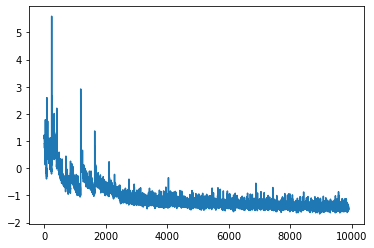

In [90]:
plot(np.array(losses[100:]))

In [100]:
batch = get_batch()
dist = optimizer.target(batch['x'])

In [105]:
tx = np.linspace(0,3.5,100)
logp = dist.log_prob(tx)

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


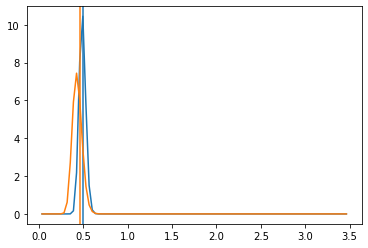

In [106]:
plot(tx, np.exp(logp[0]))
axvline(batch['y'][0], color='C0')
plot(tx, np.exp(logp[1]))
axvline(batch['y'][1], color='C1')

This plot should show the redshift posterior distribution for 
given photometry $q_\theta(z | phot)$. 

We are going to use that to compute our lower bound on the mutual information:

$$I(z; phot)  \geq \mathbb{E}_{z, phot} \left[ q_\theta(z | phot ) \right]  + H(z)$$ 

The second term in this bound only depends on the true redshift distribution, which stays constant between different opsim runs. So we only care about the first term

In [97]:
x = np.stack([phot_cat['u-g'], phot_cat['g-r'], phot_cat['r-i'],
              phot_cat['i-z'],phot_cat['z-y']]).astype('float32').T
y = np.array(phot_cat['z_true']).astype('float32').reshape((-1,1))

mutual_information_lower_bound = np.mean(model(x).log_prob(y))

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


In [107]:
mutual_information_lower_bound

DeviceArray(-26.155182, dtype=float32)

## Computing the bound for various opsim runs

In [112]:
test_cat = Table.read('dataset/weather_1.2_v1.4_10yrs/test.cat', format='ascii')

names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
z_cat = Table.read('dataset/weather_1.2_v1.4_10yrs/zphot.cat', 
                       format='ascii', 
                       names=names_z)

names_phot=('ID', 'z_true', 
        'u', 'g', 'r', 'i', 'z', 'y', 
        'err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y', 
        'u-g', 'g-r', 'r-i', 'i-z', 'z-y',
        'err_u-g', 'err_g-r', 'err_r-i', 'err_i-z', 'err_z-y')
phot_cat = Table.read('dataset/weather_1.2_v1.4_10yrs/test.cat', 
                       format='ascii', 
                       names=names_phot)
phot_cat = Table.from_pandas(phot_cat.to_pandas().dropna())

In [113]:
batch_size = 512
def get_batch():
  inds = onp.random.choice(len(phot_cat), size=batch_size)
  x = np.stack([phot_cat['u-g'][inds], phot_cat['g-r'][inds], phot_cat['r-i'][inds],
                phot_cat['i-z'][inds],phot_cat['z-y'][inds] ]).astype('float32').T
  y = np.array(phot_cat['z_true'][inds]).astype('float32').reshape((-1,1))
  return {'x':x, 'y':y}

In [114]:
_, initial_params = ConditionalDensityEstimator.init_by_shape(jax.random.PRNGKey(0),
                                           [((1, 5), np.float32)])

model = flax.nn.Model(ConditionalDensityEstimator, initial_params)

optimizer = flax.optim.Adam(learning_rate=0.001).create(model)

losses = []

In [115]:
for epoch in range(10000):
  batch = get_batch()
  optimizer, l = train_step(optimizer, batch)
  if epoch % 1000 == 0:
    print(epoch, l)
  losses.append(l)

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


0 24.113823
1000 0.34564108
2000 -0.09033154
3000 -0.63496363
4000 -0.85043794
5000 -1.0570939
6000 -1.3643892
7000 -1.2984409
8000 -1.4348577
9000 -1.5217957


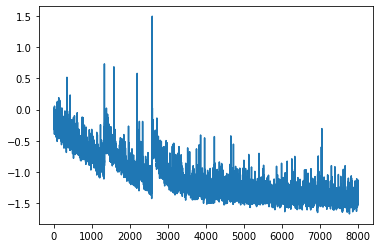

In [122]:
plot(np.array(losses[2000:]))

In [123]:
batch = get_batch()
dist = optimizer.target(batch['x'])

In [124]:
tx = np.linspace(0,3.5,100)
logp = dist.log_prob(tx)

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


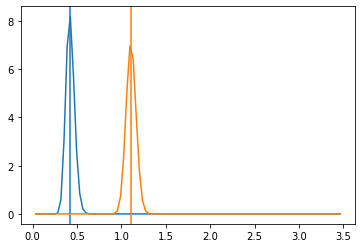

In [125]:
plot(tx, np.exp(logp[0]))
axvline(batch['y'][0], color='C0')
plot(tx, np.exp(logp[1]))
axvline(batch['y'][1], color='C1')

In [119]:
x = np.stack([phot_cat['u-g'], phot_cat['g-r'], phot_cat['r-i'],
              phot_cat['i-z'],phot_cat['z-y']]).astype('float32').T
y = np.array(phot_cat['z_true']).astype('float32').reshape((-1,1))

mutual_information_lower_bound = np.mean(model(x).log_prob(y))

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


In [120]:
mutual_information_lower_bound

DeviceArray(-26.551416, dtype=float32)